In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import lightgbm as lgb
from sklearn.model_selection import KFold
from imblearn.metrics import  geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [2]:
missing_values = ["n/a", "na", "--", "?"]
cancer_df = pd.read_csv('/Cancer.txt', na_values = missing_values)

cancer_df



,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10.0,3,2,1,2
1,1015425,3,1,1,1,2,2.0,3,1,1,2
2,1016277,6,8,8,1,3,4.0,3,7,1,2
3,1017023,4,1,1,3,2,1.0,3,1,1,2
4,1017122,8,10,10,8,7,10.0,9,7,1,4
...,...,...,...,...,...,...,...,...,...,...,...
693,776715,3,1,1,1,3,2.0,1,1,1,2
694,841769,2,1,1,1,2,1.0,1,1,1,2
695,888820,5,10,10,3,7,3.0,8,10,2,4
696,897471,4,8,6,4,3,4.0,10,6,1,4


In [3]:
cancer_df.columns = ['Sample code number', 'Clump Thickness ', 'Uniformity of Cell Size ', 'Uniformity of Cell Shape', 
                   'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
              'Normal Nucleoli ','Mitoses', 'Class']
cancer_df


,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10.0,3,2,1,2
1,1015425,3,1,1,1,2,2.0,3,1,1,2
2,1016277,6,8,8,1,3,4.0,3,7,1,2
3,1017023,4,1,1,3,2,1.0,3,1,1,2
4,1017122,8,10,10,8,7,10.0,9,7,1,4
...,...,...,...,...,...,...,...,...,...,...,...
693,776715,3,1,1,1,3,2.0,1,1,1,2
694,841769,2,1,1,1,2,1.0,1,1,1,2
695,888820,5,10,10,3,7,3.0,8,10,2,4
696,897471,4,8,6,4,3,4.0,10,6,1,4


In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sample code number           698 non-null    int64  
 1   Clump Thickness              698 non-null    int64  
 2   Uniformity of Cell Size      698 non-null    int64  
 3   Uniformity of Cell Shape     698 non-null    int64  
 4   Marginal Adhesion            698 non-null    int64  
 5   Single Epithelial Cell Size  698 non-null    int64  
 6   Bare Nuclei                  682 non-null    float64
 7   Bland Chromatin              698 non-null    int64  
 8   Normal Nucleoli              698 non-null    int64  
 9   Mitoses                      698 non-null    int64  
 10  Class                        698 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.1 KB


Sample code number              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64


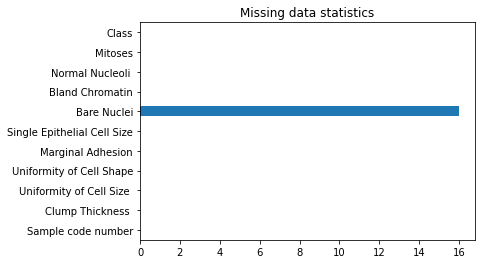

In [5]:
c = cancer_df.isnull().sum()
plt.title("Missing data statistics")
c.plot(kind='barh')
print(c)

In [7]:
cancer_df = cancer_df.dropna() 

Count of Benign patients 443
Count of Malignant patients 239


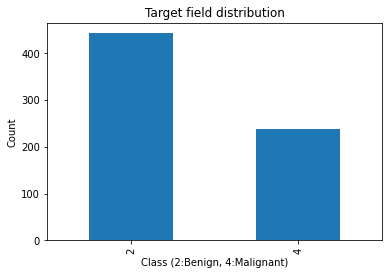

In [8]:
benign, malignant = cancer_df['Class'].value_counts()
print('Count of Benign patients', benign)
print('Count of Malignant patients', malignant)
cancer_df['Class'].value_counts().plot(kind='bar', title='Target field distribution')

plt.ylabel('Count')
plt.xlabel('Class (2:Benign, 4:Malignant)')
plt.show()


In [9]:
replace = {"Class":     {2: 1, 4: 0}}
cancer_df = cancer_df.replace(replace)
cancer_df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10.0,3,2,1,1
1,1015425,3,1,1,1,2,2.0,3,1,1,1
2,1016277,6,8,8,1,3,4.0,3,7,1,1
3,1017023,4,1,1,3,2,1.0,3,1,1,1
4,1017122,8,10,10,8,7,10.0,9,7,1,0


Count of positive records 443
Count of negative records 239


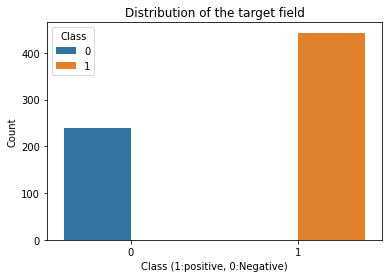

In [10]:
benign, malignant = cancer_df['Class'].value_counts()
print('Count of positive records', benign)
print('Count of negative records', malignant)
sns.countplot(x="Class", hue="Class", data=cancer_df)
plt.ylabel('Count')
plt.xlabel('Class (1:positive, 0:Negative)')
plt.title('Distribution of the target field')
plt.show()

In [11]:
x= cancer_df.drop(['Class','Sample code number'], axis=1)
x
y = cancer_df['Class']
print(x)


     Clump Thickness   Uniformity of Cell Size   ...  Normal Nucleoli   Mitoses
0                   5                         4  ...                 2        1
1                   3                         1  ...                 1        1
2                   6                         8  ...                 7        1
3                   4                         1  ...                 1        1
4                   8                        10  ...                 7        1
..                ...                       ...  ...               ...      ...
693                 3                         1  ...                 1        1
694                 2                         1  ...                 1        1
695                 5                        10  ...                10        2
696                 4                         8  ...                 6        1
697                 4                         8  ...                 4        1

[682 rows x 9 columns]


# AIS Algorithm functions

In [12]:
def initilization_of_population_featurebased(size,n_feat):
    population = []
    random.seed(10)
    for j in range(size): 
        chromosome = []    #chromosome type is list
        for i in range(n_feat):
            if i == 0:
                gene = random.randint(1, 6)
            elif i == 1:
                gene = 1
            elif i == 2:
                gene = random.randint(1,3)
            elif i == 3:
                gene = random.randint(1, 3)
            elif i == 4:
                gene = random.randint(2,6)
            elif i == 5:
                gene = random.randint(1,5)
            elif i == 6:
                gene = random.randint(2,3)
            elif i == 7:
                gene = random.randint(1,2)
            else:
                gene = 1
            chromosome.append(gene)
        population.append(chromosome)
    return(population)

In [13]:
def fitness_score(population,model,X_train,X_test, y_train, y_test):
    scores = []
    for chromosome in population:
        a_series = pd.Series(chromosome, index = X_train.columns)
        b_series = pd.Series([0])
        X_train_with_chromosome = X_train.append(a_series, ignore_index=True)
        y_train_with_chromosome = y_train.append(b_series, ignore_index=True)
        model.fit(X_train_with_chromosome,np.ravel(y_train_with_chromosome))
        predictions = model.predict(X_test)
        scores.append(f1_score(np.ravel(y_test), predictions))
    scores, population = np.array(scores), np.array(population) # list of arrays scores = [[array1],[array2]]
    inds = np.argsort(scores) #[2, 3, 1, 0] indicates that the smallest element is at index 2, the next smallest at index 3, then index 1, then index 0.
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) #list of list (converting each array such as array, array2  0 to list in sorted order)

In [14]:
def selection(pop_after_fit,n_parents):
    population_nextgen = [] #New array 
    for i in range(n_parents): 
        population_nextgen.append(pop_after_fit[i])  # append the best chromosomes as parents from results after fit function
    return population_nextgen 

In [15]:
def clone(pop_after_sel, clone_rate):
    population_next_gen_cloned = []
    population_next_gen=pop_after_sel
    for x in range(clone_rate):
            for i in range(len(population_next_gen)):
                clones = population_next_gen[i]
                population_next_gen_cloned.append(clones)
    return population_next_gen_cloned
    

In [16]:
def mutation_clone(pop_after_clone,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_clone)):  #consider each chromoseome from the cross over set
        chromosome = pop_after_clone[i]  #take in sequence one after other chromosomes
        for j in range(len(chromosome)):  #with the one chromosome array
            if j == 0:  #Up to us can be anything here we see if randomly generated value < mutate
                chromosome[j] = int(chromosome[j] + (mutation_rate * 5))
            elif j== 1:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 1))
            elif j== 2:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 2))
            elif j== 3:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 2))
            elif j== 4:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 4))
            elif j== 5:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 4))
            elif j== 6:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 1))
            elif j== 7:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 1))
            else:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 1))
        population_nextgen.append(chromosome)  #append all the changed ones to next_gen
    
    return population_nextgen

In [17]:
def generations(size,n_feat,n_parents,mutation_rate, clone_rate,model,X_train,X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    stop_condition = True
    i = 0
    fscore_counter = 0
    bestscore_counter = 0
    population_nextgen=initilization_of_population_featurebased(size,n_feat)
    print('Initial random population based on minority class features')
    print(population_nextgen)
    while stop_condition:
        print(i)
        print('--------------------------------------------------------------------------')
        scores, pop_after_fit = fitness_score(population_nextgen, model,X_train,X_test, y_train, y_test)
        print('Scores of each chromosomes in sorted order')
        print(scores)
        print('Chromosome set sorted and corresponding to scores')
        print(pop_after_fit)
        pop_after_sel = selection(pop_after_fit,n_parents)
        print('Selects the best parents to generate better chromosomes for next generation')
        print(pop_after_sel)
        print("Clone after selection based on clone_rate")
        pop_after_clone = clone(pop_after_sel, clone_rate)
        print(pop_after_clone)
        print('Mutate the cloned population')
        population_nextgen = mutation_clone(pop_after_clone,mutation_rate)
        print(population_nextgen)
        if i > 0:
             if round(best_score[-1],5) >= round(scores[0],5):
                    print("Checking if the values are degrading or equal")
                    fscore_counter = fscore_counter + 1
                    print(fscore_counter)
                    if fscore_counter == 10 :
                        print("&&&&&&&&&--------Fscore_counter is checked and near to 10--------&&&&&&&&&&&&&")
                        stop_condition = False
                        
             elif stop_condition == True:
                if round(best_score[-1],5) < round(scores[0],5):
                    print("&&&&&&&&&&&&&&-----Fscore_counter is recompiled to O-------&&&&&&&&&&&&&&&&&")
                    fscore_counter = 0
             if stop_condition == True:
                if len(best_score) > 150:
                    print("-----Length of best score is exceeded so stopping the AIS now--------")
                    stop_condition = False
             #else:
               # stop_condition = True
                    
        i = i + 1
        
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('best score and chromosome')
        print(best_chromo)
        print(best_score)
        
    return best_chromo, best_score

In [27]:
def update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train):
    X_train = Initial_X_train
    y_train = Initial_y_train
    for best_chromo in chromo:
        X_train_bestchromo = []
        a_series = pd.Series(best_chromo, index = X_train.columns)
        b_series = pd.Series([0])
        X_train_bestchromo = X_train.append(a_series, ignore_index=True)
        X_train = X_train_bestchromo
        y_train_bestchromo = y_train.append(b_series, ignore_index=True)
        y_train = y_train_bestchromo
    return X_train, y_train

In [19]:
def modelling_using_AIS_SampledTrainset(AIS_X_train, AIS_y_train, AIS_X_test, AIS_y_test,classifier):
    model = classifier
    model.fit(AIS_X_train,np.ravel(AIS_y_train))
    predictions = model.predict(AIS_X_test)
    acc, recal, precis, aucroc, gmean, _val = evaluation(predictions, AIS_y_test)
    
    return acc, recal, precis, aucroc, gmean, _val
    
    

In [20]:
def evaluation(pred_values, y_test):
    
    acc = accuracy_score(np.ravel(y_test), pred_values)
    recal = recall_score(np.ravel(y_test), pred_values)
    precis = precision_score(np.ravel(y_test), pred_values)
    #val = f1_score(y_test, pred_values)
    aucroc = roc_auc_score(np.ravel(y_test), pred_values)
    _val = f1_score(np.ravel(y_test), pred_values)
    gmean = geometric_mean_score(np.ravel(y_test), pred_values)
    
    return acc, recal, precis, aucroc, gmean, _val

# AIS algorithm on Train and Test datasets function

In [21]:
def AIS_sampling_and_modelling(x,y,model,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(X_train_AISsampled, y_train_AISsampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

In [22]:
def AIS_with_resampling(x,y,model,sampler,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    sampleclassifier = sampler
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('----------------*****Applying sampling {0} technique on updated AIS train datasets******----------'.format(sampleclassifier))
        AIS_X_train_sampled, AIS_y_train_sampled = sampleclassifier.fit_resample(X_train_AISsampled, np.ravel(y_train_AISsampled))
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(AIS_X_train_sampled, AIS_y_train_sampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

# Random Forest Model

In [ ]:
RandomForestModel = RandomForestClassifier(random_state = 24)
random.seed(1)

AIS_sampling_and_modelling(x,y,model = RandomForestModel,size = 10,n_feat =x.shape[1] ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([4, 1, 2, 3, 2, 5,

# Ada Boosting Classifier

In [23]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoostModel = AdaBoostClassifier()

In [ ]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 10,n_feat = x.shape[1] ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9666666666666667, 0.9666666666666667, 0.9662921348314607, 0.9613259668508287, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([

In [ ]:
lgbmodel = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)

In [ ]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = lgbmodel,size = 10,n_feat =x.shape[1] ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9662921348314607, 0.9613259668508287, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557, 0.9555555555555557, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([2, 1, 

# Random Forest +SMOTE +ADASYN

In [24]:
sampler_smt = SMOTE(random_state=0)
sampler_ada = ADASYN(random_state=0)


In [ ]:
 AIS_with_resampling(x,y,model = RandomForestModel,sampler = sampler_smt,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([4, 1, 2, 3, 2, 5,

In [ ]:

AIS_with_resampling(x,y,model = RandomForestModel,sampler = sampler_ada,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)


--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([4, 1, 2, 3, 2, 5,

In [ ]:
sampler_nearmiss = NearMiss()
AIS_with_resampling(x,y,model = RandomForestModel,sampler = sampler_nearmiss,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)


--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([4, 1, 2, 3, 2, 5,

# LGB Classifier + SMOTE+ ADASYN

In [ ]:
AIS_with_resampling(x,y,model = lgbmodel,sampler = sampler_smt,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9662921348314607, 0.9613259668508287, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557, 0.9555555555555557, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([2, 1, 

In [ ]:
AIS_with_resampling(x,y,model = lgbmodel,sampler = sampler_nearmiss,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9662921348314607, 0.9613259668508287, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9555555555555557, 0.9555555555555557, 0.9555555555555557]
Chromosome set sorted and corresponding to scores
[array([2, 1, 

In [28]:
AIS_with_resampling(x,y,model = AdaBoostModel,sampler = sampler_smt,size = 10,n_feat =x.shape[1] ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9666666666666667, 0.9666666666666667, 0.9662921348314607, 0.9613259668508287, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[0.978494623655914, 0.9782608695652174, 0.9732620320855615, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.9726775956284154, 0.9726775956284154, 0.967741935483871, 0.967391304347826]
Chromosome set sorted and corresponding to scores
[array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1])]
Clone after selection based on clone_rate
[array([6, 1, 3,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[0.9599999999999999, 0.9599999999999999, 0.9599999999999999, 0.9599999999999999, 0.9545454545454545, 0.9545454545454545, 0.9540229885057472, 0.9491525423728814, 0.9491525423728814, 0.9491525423728814]
Chromosome set sorted and corresponding to scores
[array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1])]
Clone after selection based on clone_rate
[array([4,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[1.0, 0.9942857142857142, 0.9942857142857142, 0.9886363636363636, 0.9886363636363636, 0.983050847457627, 0.9828571428571428, 0.9828571428571428, 0.9828571428571428, 0.9828571428571428]
Chromosome set sorted and corresponding to scores
[array([5, 1, 1, 2, 5, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([5, 1, 1, 2, 5, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1])]
Clone after selection based on clone_rate
[array([5, 1, 1, 2, 5, 5, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[0.9714285714285714, 0.9710982658959537, 0.9659090909090909, 0.9659090909090909, 0.96045197740113, 0.96, 0.96, 0.96, 0.9545454545454546, 0.9545454545454546]
Chromosome set sorted and corresponding to scores
[array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1])]
Clone after selection based on clone_rate
[array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([2, 1, 1, 2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
AIS_with_resampling(x,y,model = AdaBoostModel,sampler = sampler_ada,size = 10,n_feat =x.shape[1] ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[5, 1, 1, 2, 5, 5, 2, 1, 1], [4, 1, 2, 2, 3, 1, 3, 2, 1], [1, 1, 1, 3, 4, 1, 3, 1, 1], [5, 1, 2, 2, 5, 3, 3, 2, 1], [2, 1, 3, 2, 4, 2, 3, 1, 1], [4, 1, 3, 2, 2, 5, 2, 1, 1], [2, 1, 1, 2, 6, 3, 2, 2, 1], [6, 1, 3, 2, 5, 4, 2, 2, 1], [5, 1, 1, 1, 5, 2, 2, 1, 1], [4, 1, 2, 3, 2, 5, 2, 1, 1]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.9666666666666667, 0.9666666666666667, 0.9662921348314607, 0.9613259668508287, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 0.9608938547486034, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[0.978494623655914, 0.9782608695652174, 0.9732620320855615, 0.972972972972973, 0.972972972972973, 0.972972972972973, 0.9726775956284154, 0.9726775956284154, 0.967741935483871, 0.967391304347826]
Chromosome set sorted and corresponding to scores
[array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1])]
Clone after selection based on clone_rate
[array([6, 1, 3,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[0.9599999999999999, 0.9599999999999999, 0.9599999999999999, 0.9599999999999999, 0.9545454545454545, 0.9545454545454545, 0.9540229885057472, 0.9491525423728814, 0.9491525423728814, 0.9491525423728814]
Chromosome set sorted and corresponding to scores
[array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1])]
Clone after selection based on clone_rate
[array([4,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[1.0, 0.9942857142857142, 0.9942857142857142, 0.9886363636363636, 0.9886363636363636, 0.983050847457627, 0.9828571428571428, 0.9828571428571428, 0.9828571428571428, 0.9828571428571428]
Chromosome set sorted and corresponding to scores
[array([5, 1, 1, 2, 5, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([5, 1, 1, 2, 5, 5, 2, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1])]
Clone after selection based on clone_rate
[array([5, 1, 1, 2, 5, 5, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Scores of each chromosomes in sorted order
[0.9714285714285714, 0.9710982658959537, 0.9659090909090909, 0.9659090909090909, 0.96045197740113, 0.96, 0.96, 0.96, 0.9545454545454546, 0.9545454545454546]
Chromosome set sorted and corresponding to scores
[array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1]), array([6, 1, 3, 2, 5, 4, 2, 2, 1]), array([4, 1, 2, 2, 3, 1, 3, 2, 1]), array([4, 1, 3, 2, 2, 5, 2, 1, 1]), array([5, 1, 1, 2, 5, 5, 2, 1, 1])]
Selects the best parents to generate better chromosomes for next generation
[array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([2, 1, 1, 2, 6, 3, 2, 2, 1]), array([5, 1, 1, 1, 5, 2, 2, 1, 1]), array([5, 1, 2, 2, 5, 3, 3, 2, 1]), array([1, 1, 1, 3, 4, 1, 3, 1, 1]), array([4, 1, 2, 3, 2, 5, 2, 1, 1])]
Clone after selection based on clone_rate
[array([2, 1, 3, 2, 4, 2, 3, 1, 1]), array([2, 1, 1, 2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
